# 5 Normalization

I’m now going to prepare the 21 final indicators for aggregation by:

1. **Dropping** the intermediate or unwanted series  
2. **Log-transforming** the most skewed, strictly positive variables  
3. **Rescaling** all remaining indicators to [0, 1] via **min–max**  

This follows the Handbook’s guide on scale comparability and interpretability in STEP 5 Normalization.

## 5.1 Drop unused indicators

First, I load the full dataset and remove the nine variables I decided not to carry forward:

In [20]:
import pandas as pd
from pathlib import Path

ROOT     = Path("..")
PROC_DIR = ROOT / "data" / "processed"
INPUT    = PROC_DIR / "csiai_input_complete.parquet"

drop_vars = [
    "quick_ratio", "total_revenue", "analyst_rating", "rnd_to_revenue",
    "ev_to_ebitda", "pb_ratio", "sharpe_ratio", "turnover_ratio",
    "shares_outstanding"
]

df = pd.read_parquet(INPUT)
if "ticker" in df.columns:
    df = df.set_index("ticker")

df = df.drop(columns=drop_vars)

display(df.head())

,roe,debt_to_equity,current_ratio,oper_cash_flow,ebitda_margin,revenue_growth,operating_margin,gross_margin,eps,market_cap,...,payout_ratio,hist_volatility,beta,max_drawdown,stddev_returns,value_at_risk,avg_volume_30d,bid_ask_spread,volume_growth,float_shares
ticker,,,,,,,,,,,,,,,,,,,,,
COOP,0.123940,252.02500,1.777,-5.250000e+08,0.83521,-0.7,0.25000,1.00000,8.98,7.416548e+09,...,0.0000,82.701587,1.063000,-47.864469,2.797903,7.712597,8.934867e+05,2.090564,-71.193591,62857966.0
XYL,0.085050,19.32300,1.886,1.207000e+09,0.20086,1.8,0.12131,0.37544,3.71,2.952334e+10,...,0.3989,80.216734,1.097000,-39.984379,2.529285,7.371736,2.388650e+06,4.326513,-73.628614,241713259.0
MAR,0.394964,0.43428,0.403,2.749000e+09,0.64340,2.9,0.48406,0.81868,8.33,6.922601e+10,...,0.2893,43.264000,1.389000,-26.012920,1.736512,4.020886,1.380357e+06,3.017593,-43.061028,240863954.0
ALSN,0.501500,395.89900,3.051,8.090000e+08,0.35415,20.4,0.27329,0.48126,8.64,8.194201e+09,...,0.1181,60.321805,0.964000,-26.417769,2.222237,5.479576,4.503433e+05,1.984674,-10.067925,100944930.0
DHC,-0.139620,143.75400,14.349,8.037800e+07,0.15743,4.3,-0.01244,0.17585,-1.55,7.104400e+08,...,0.0230,55.559339,0.943252,-61.173793,2.717047,5.158732,2.239300e+05,4.009016,-45.633991,186291521.0


## 5.2 Inspect skewness

I check which of the remaining 21 indicators are highly skewed (to decide on log1p) for transformation

Top five positively skewed:
 revenue_growth    41.824588
price_to_sales    27.334368
volume_growth     17.793841
float_shares      16.954254
market_cap        15.876538
dtype: float64

Top five negatively skewed:
 beta                 0.846465
max_drawdown        -0.502473
gross_margin        -2.103167
ebitda_margin       -3.116495
operating_margin   -43.574038
dtype: float64


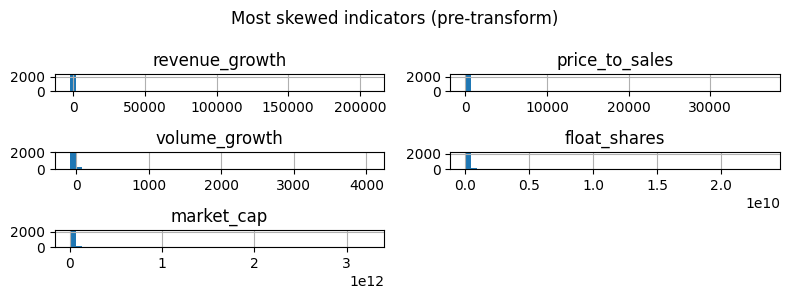

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
skewness = df.skew().sort_values(ascending=False)
print("Top five positively skewed:\n", skewness.head(5))
print("\nTop five negatively skewed:\n", skewness.tail(5))

# histogram of most skewed variables
most_skewed = list(skewness.head(5).index)
df[most_skewed].hist(bins=50, figsize=(8,3))
plt.suptitle("Most skewed indicators (pre-transform)")
plt.tight_layout()
plt.show()

## 5.3. Log-transform highly skewed series

Based on the skewness, I log1p transform those that are strictly positive because in the handbok it says skewed data can distort results.

In [22]:
import numpy as np

# log-transform skewed variables
# to_log = [
#     "revenue_growth", "price_to_sales", "volume_growth",
#     "market_cap", "float_shares"
# ]

# to_log = [c for c in to_log if c in df.columns]
# df[to_log] = np.log1p(df[to_log])

# I commented out the log-transform because it doesn't seem to help it creates issues with trying to do a straight np on zero values
# So i will use PowerTransformer instead
from sklearn.preprocessing import PowerTransformer

# create a Yeo–Johnson transformer
pt = PowerTransformer(method="yeo-johnson", standardize=False)

df_yt = pd.DataFrame(
    pt.fit_transform(df.values),
    index=df.index,
    columns=df.columns
)

## 5.4. Min–max scaling to [0, 1]

I apply scikit-learn’s MinMaxScaler to the 21 indicators

In [23]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(df_yt.values)

df_norm = pd.DataFrame(
    scaled,
    index=df_yt.index,
    columns=df_yt.columns
)

print("Min values:\n", df_norm.min().round(3).head())
print("Max values:\n", df_norm.max().round(3).head())

Min values:
 roe               0.0
debt_to_equity    0.0
current_ratio     0.0
oper_cash_flow    0.0
ebitda_margin     0.0
dtype: float64
Max values:
 roe               1.0
debt_to_equity    1.0
current_ratio     1.0
oper_cash_flow    1.0
ebitda_margin     1.0
dtype: float64


 ## 5.5. Save normalized dataset

In [24]:
OUTPUT = PROC_DIR / "csiai_input_normalized.parquet"
df_norm.to_parquet(OUTPUT)
print(f"Normalized data saved to {OUTPUT}")

Normalized data saved to ../data/processed/csiai_input_normalized.parquet


## 5.6. References

* Organisation for Economic Co-operation and Development: *Handbook on Constructing Composite Indicators: Methodology and User Guide*, 2008.
* Microsoft Copilot - Note that Copilot is Turned on in this notebook to do some code completion.
* ChatGPT - https://chatgpt.com/share/681d4dc8-36f0-800b-8939-d08f76061782
* Towards Data Science - https://towardsdatascience.com/top-3-methods-for-handling-skewed-data-1334e0debf45/
* GeeksforGeeks - https://www.geeksforgeeks.org/powertransformer-in-scikit-learn/